In [361]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import xgboost as xgb
from sklearn.metrics import mean_squared_error  # mean_squared_log_error

In [362]:
df = pd.read_parquet('/Users/laceymorgan/Desktop/energy/est_hourly.paruqet')
df.head()

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0


In [363]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
AEP,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.00,25695.0
COMED,66497.0,11420.152112,2304.139517,7237.0,9780.0,11152.0,12510.00,23753.0
DAYTON,121275.0,2037.851140,393.403153,982.0,1749.0,2009.0,2279.00,3746.0
DEOK,57739.0,3105.096486,599.859026,907.0,2687.0,3013.0,3449.00,5445.0
DOM,116189.0,10949.203625,2413.946569,1253.0,9322.0,10501.0,12378.00,21651.0
DUQ,119068.0,1658.820296,301.740640,1014.0,1444.0,1630.0,1819.00,3054.0
EKPC,45334.0,1464.218423,378.868404,514.0,1185.0,1386.0,1699.00,3490.0
FE,62874.0,7792.159064,1331.268006,0.0,6807.0,7700.0,8556.00,14032.0
NI,58450.0,11701.682943,2371.498701,7003.0,9954.0,11521.0,12896.75,23631.0
PJME,145366.0,32080.222831,6464.012166,14544.0,27573.0,31421.0,35650.00,62009.0


In [364]:
df.isnull().sum()

AEP          56989
COMED       111765
DAYTON       56987
DEOK        120523
DOM          62073
DUQ          59194
EKPC        132928
FE          115388
NI          119812
PJME         32896
PJMW         35056
PJM_Load    145366
dtype: int64

In [365]:
# bring Datetime index to column
df.reset_index(inplace=True)

In [366]:
df.dtypes

Datetime    datetime64[ns]
AEP                float64
COMED              float64
DAYTON             float64
DEOK               float64
DOM                float64
DUQ                float64
EKPC               float64
FE                 float64
NI                 float64
PJME               float64
PJMW               float64
PJM_Load           float64
dtype: object

In [367]:
from IPython.display import Image
Image(url= "http://slideplayer.com/4238181/14/images/4/PJM+Evolution.jpg")

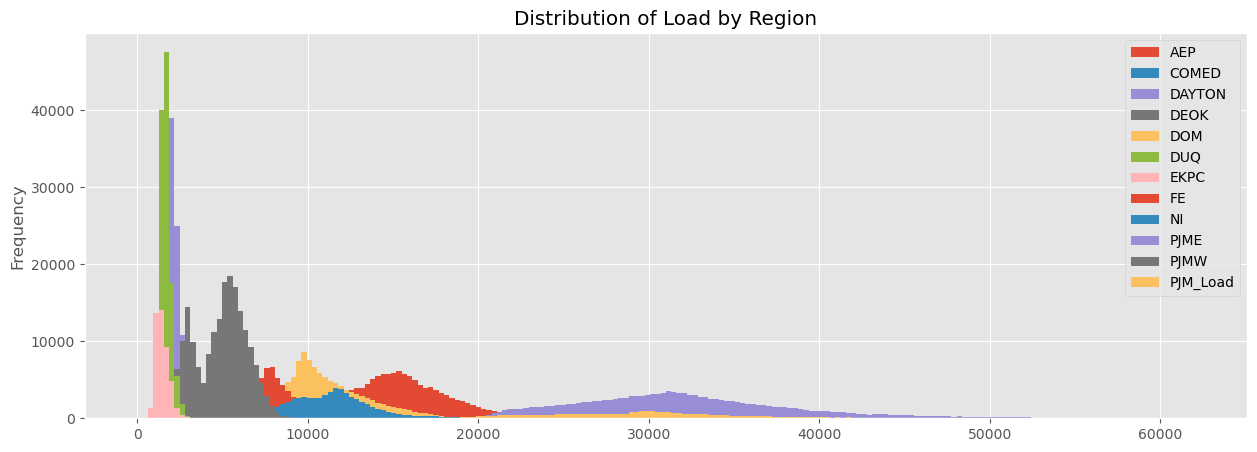

In [368]:
# Looking at distribution of load by region
df.plot.hist(figsize=(15, 5), bins=200, title='Distribution of Load by Region')
plt.show()

### Plotting timeseries

In [369]:
# set datetime as index
df.set_index('Datetime', inplace=True)

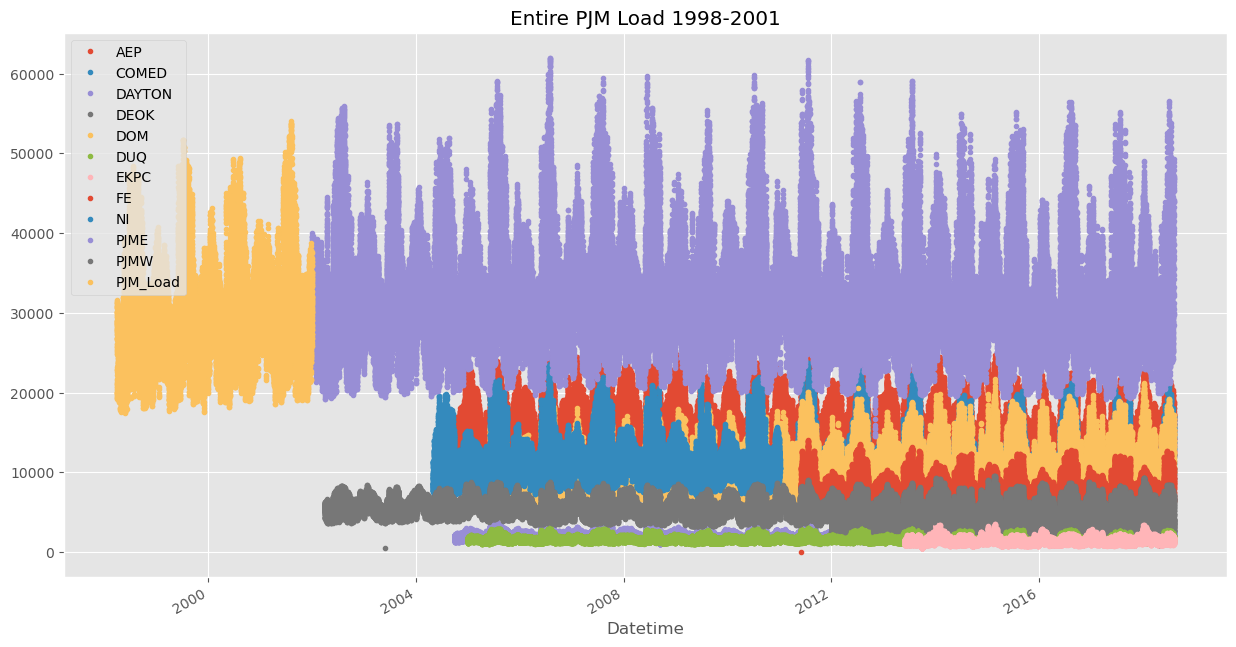

In [370]:
plot = df.plot(style='.', figsize=(15, 8), title='Entire PJM Load 1998-2001')


#### Summer Demand vs Winter Demand

We see dips mid-day in the winter months. Conversely in summer months the daily load is more bell shaped. This is due to high mid-day energy consumtion by air conditioning. In winter months people tend to use less energy mid-day.


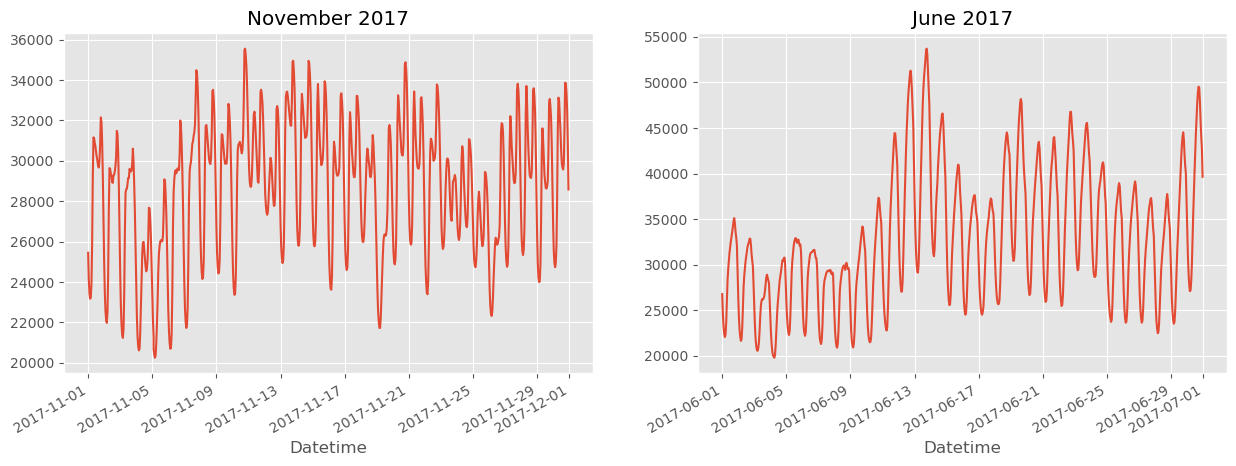

In [371]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# plot the first line on the first axis
df['PJME'].loc[(df['PJME'].index >= '2017-11-01') & (df['PJME'].index < '2017-12-01')].plot(ax=ax1, title='November 2017')

# plot the second line on the second axis
df['PJME'].loc[(df['PJME'].index >= '2017-06-01') & (df['PJME'].index < '2017-07-01')].plot(ax=ax2, title='June 2017')

# show the plot
plt.show()

#### Create timeseries features

In [372]:
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.strftime('%A')
# df['woy'] = df.index.week
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

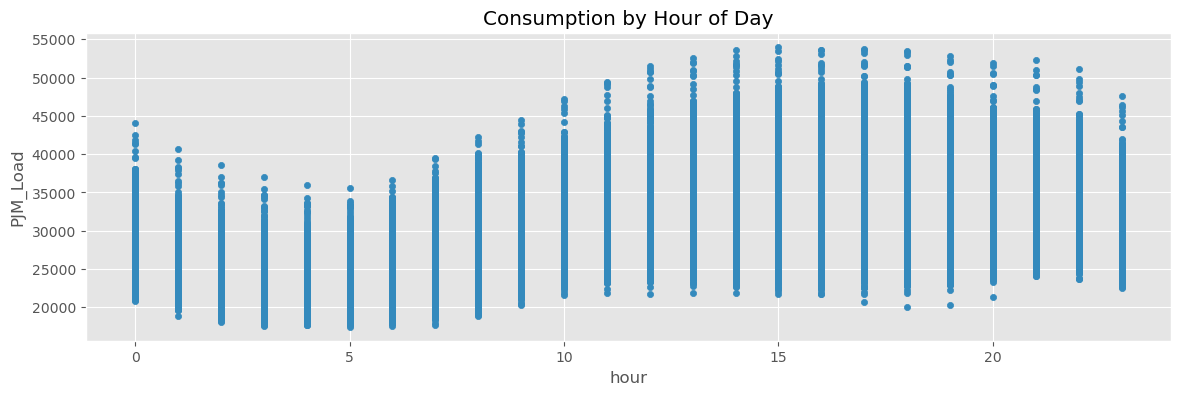

In [373]:
_ = df[['PJM_Load','hour']].plot(x='hour',
                                     y='PJM_Load',
                                     kind='scatter',
                                     figsize=(14,4),
                                     title='Consumption by Hour of Day')

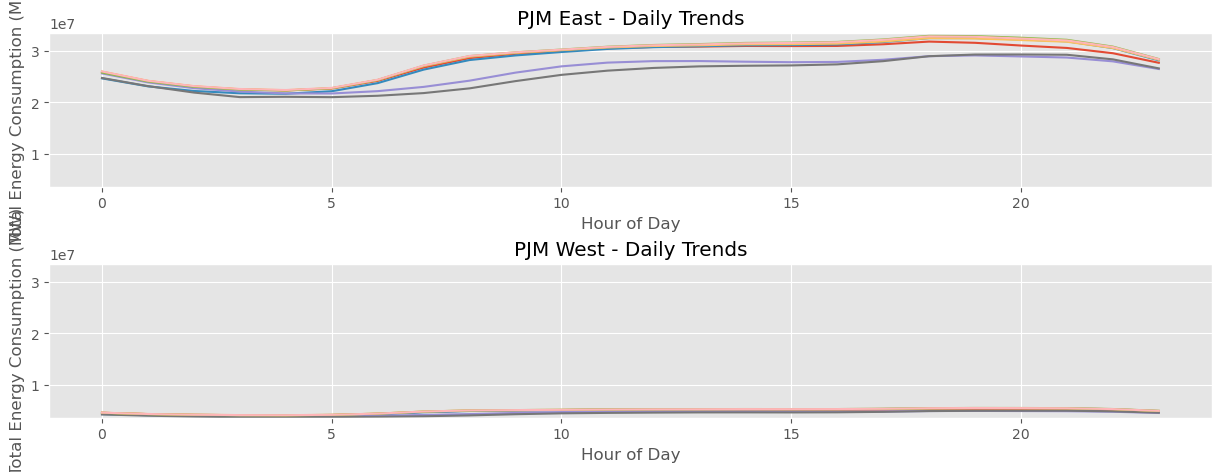

In [374]:
# show PJM East and PMJ West daily trends on the same fig

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 5))

df.pivot_table(index=df['hour'], 
               columns='weekday', 
               values='PJME',
               aggfunc='sum').plot(ax=ax1,
                                   title='PJM East - Daily Trends',
                                   legend=False)

df.pivot_table(index=df['hour'],
               columns='weekday',
               values='PJMW',
               aggfunc='sum').plot(ax=ax2,
                                   title='PJM West - Daily Trends',
                                   legend=False)

# set y limits to be the same for both plots
ymin = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

ax1.set_ylim(ymin, ymax)
ax2.set_ylim(ymin, ymax)

ax1.set_ylabel('Total Energy Consumption (MW)')
ax2.set_ylabel('Total Energy Consumption (MW)')
ax1.set_xlabel('Hour of Day')
ax2.set_xlabel('Hour of Day')

fig.subplots_adjust(hspace=0.5)

plt.show()


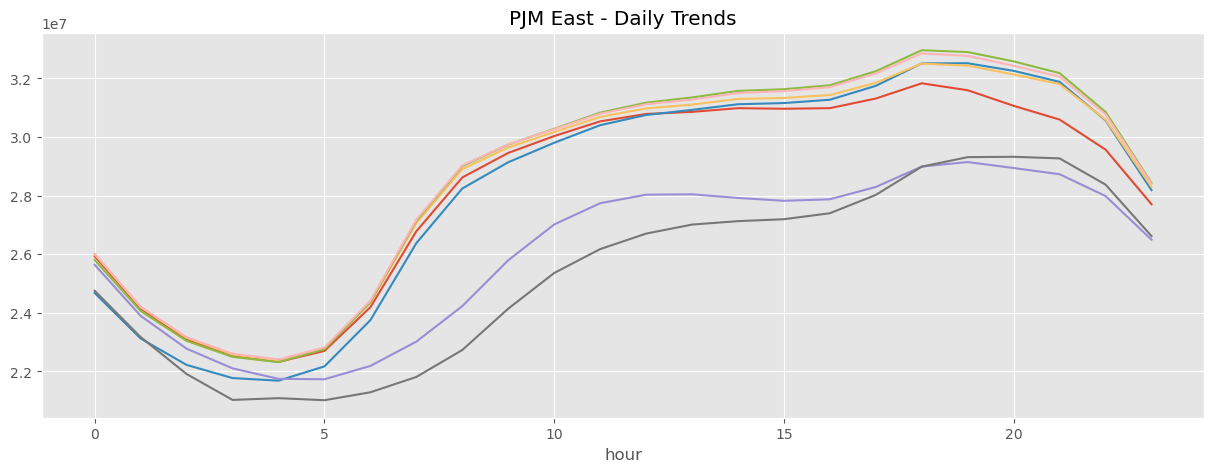

In [375]:
# Looking at just PJM East
df.pivot_table(index=df['hour'], 
               columns='weekday', 
               values='PJME',
               aggfunc='sum').plot(figsize=(15, 5),
                            title='PJM East - Daily Trends',
                            legend=False)

plt.show()

### Looking at just PJM East for building a regression model

In [376]:
pjm3_df = df[['PJME']].set_index(pd.to_datetime(df.index))
pjm3_df.head()

,PJME
Datetime,
1998-12-31 01:00:00,NaN
1998-12-31 02:00:00,NaN
1998-12-31 03:00:00,NaN
1998-12-31 04:00:00,NaN
1998-12-31 05:00:00,NaN


In [377]:
pjm3_df.isnull().sum()

PJME    32896
dtype: int64

In [378]:
# drop null values
pjm3_df.dropna(inplace=True)

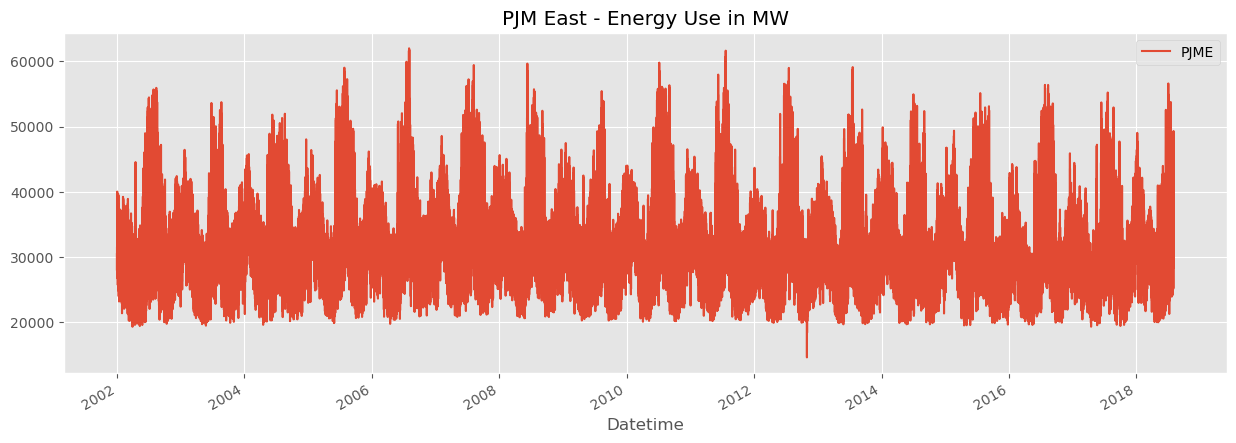

In [379]:
# Visualize the time series data
pjm3_df.plot(figsize=(15, 5), title='PJM East - Energy Use in MW')

plt.show()

In [380]:
train= pjm3_df.loc[pjm3_df.index < '2015-01-01']
test= pjm3_df.loc[pjm3_df.index >= '2015-01-01']

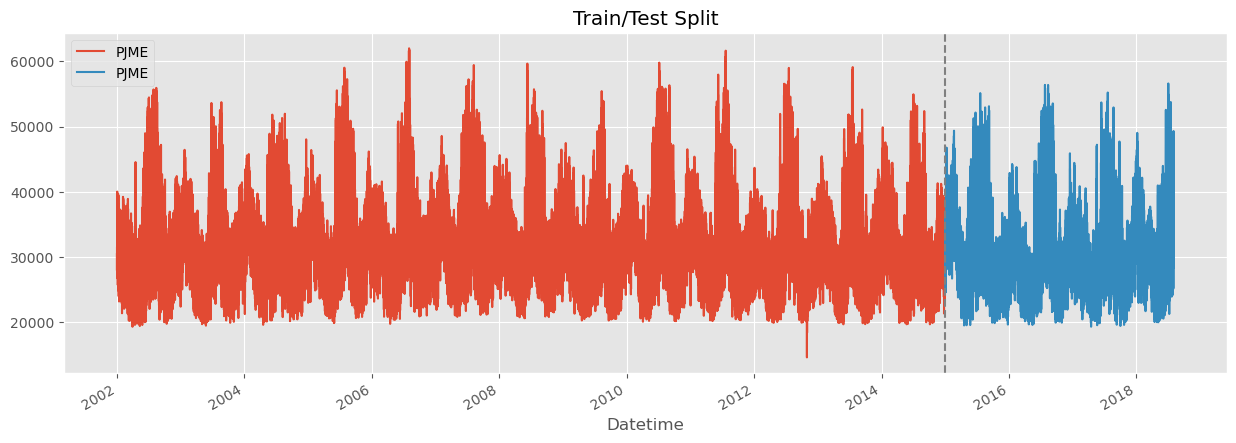

In [381]:
# Visualize the split

fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Train')
test.plot(ax=ax, label='Test')
ax.axvline(x='2015-01-01', linestyle='--', color='gray')
ax.set_title('Train/Test Split')

plt.show()

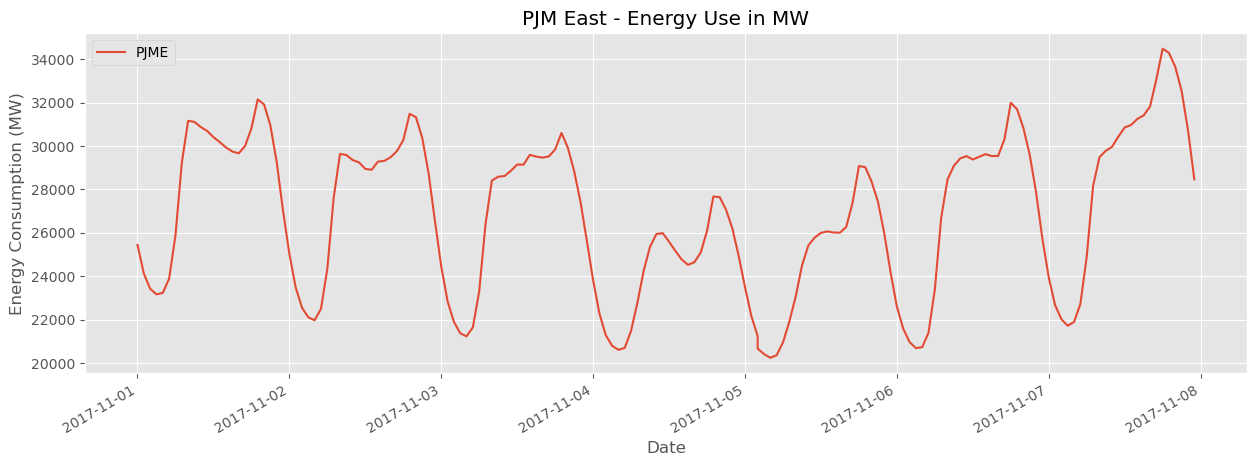

In [382]:
# looking at a week of data
test.loc[(test.index >= '2017-11-01') & (test.index < '2017-11-08')].\
    plot(figsize=(15, 5), title='PJM East - Energy Use in MW')

plt.ylabel('Energy Consumption (MW)')
plt.xlabel('Date')

plt.show()

### Feature creation

In [383]:
def create_features(df):
    """
    Creates time series features from datetime index
    """
    
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df


In [384]:
test = test.copy()
create_features(test)

,PJME,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365
...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1


In [385]:
train = train.copy()
create_features(train)

,PJME,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365
...,...,...,...,...,...,...,...
2014-01-01 20:00:00,36193.0,20,2,1,1,2014,1
2014-01-01 21:00:00,35601.0,21,2,1,1,2014,1
2014-01-01 22:00:00,34242.0,22,2,1,1,2014,1


Visualize Feature/Target Relationship

Text(0.5, 0, 'Hour of Day')

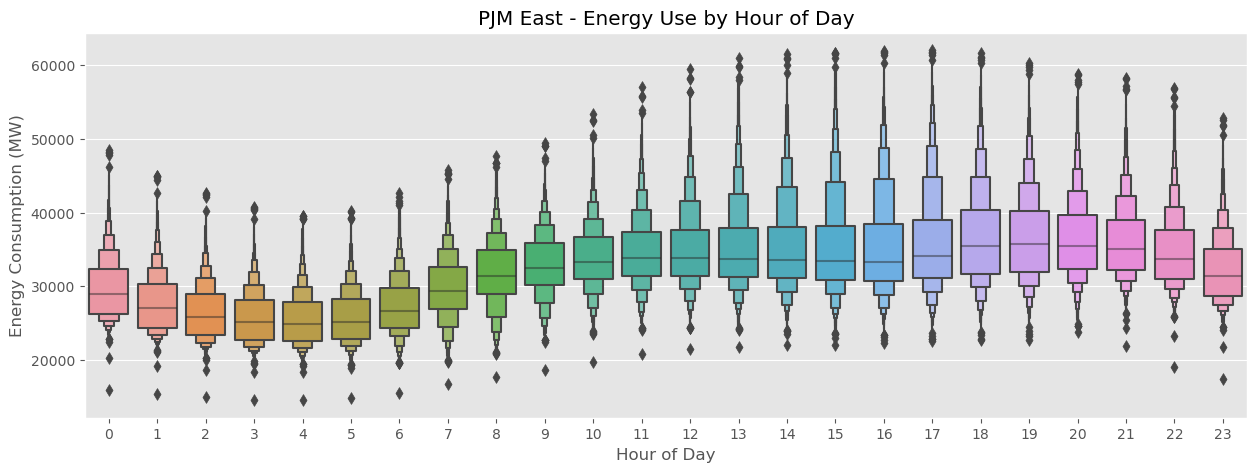

In [386]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxenplot(data=train, x='hour', y='PJME', ax=ax)
ax.set_title('PJM East - Energy Use by Hour of Day')
ax.set_ylabel('Energy Consumption (MW)')
ax.set_xlabel('Hour of Day')

Text(0.5, 0, 'Month')

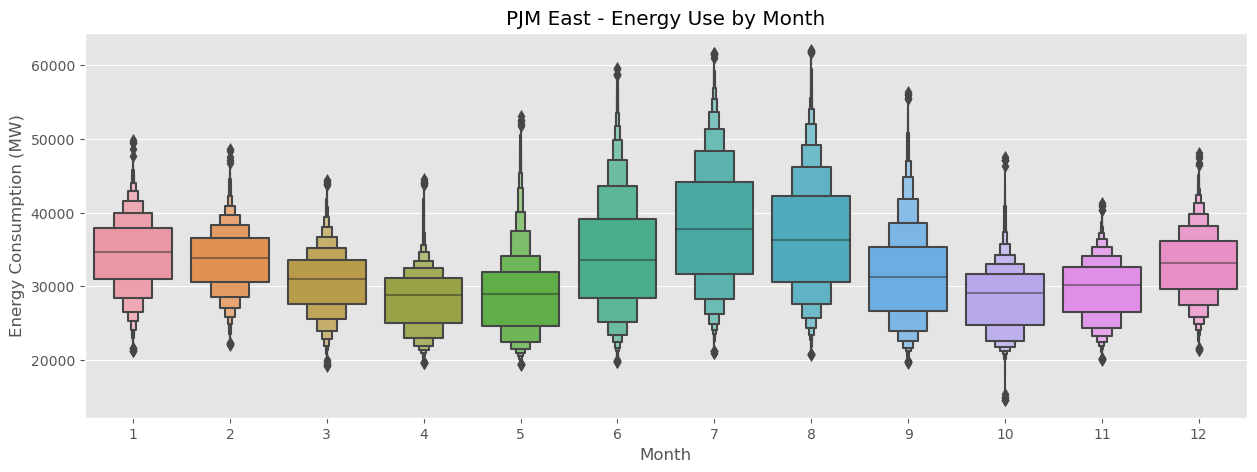

In [387]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.boxenplot(data=train, x='month', y='PJME', ax=ax)
ax.set_title('PJM East - Energy Use by Month')
ax.set_ylabel('Energy Consumption (MW)')
ax.set_xlabel('Month')

### Create Model

In [388]:
train.columns

Index(['PJME', 'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear'], dtype='object')

In [389]:
FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = ['PJME']

In [390]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


In [391]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                       learning_rate=0.1) 
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=True)

[0]	validation_0-rmse:29676.17870	validation_1-rmse:28732.06789
[1]	validation_0-rmse:26754.48086	validation_1-rmse:25796.71425
[2]	validation_0-rmse:24128.08882	validation_1-rmse:23182.77540
[3]	validation_0-rmse:21768.12573	validation_1-rmse:20830.31759
[4]	validation_0-rmse:19649.53432	validation_1-rmse:18735.25923
[5]	validation_0-rmse:17746.02850	validation_1-rmse:16859.42394
[6]	validation_0-rmse:16040.20153	validation_1-rmse:15180.60453
[7]	validation_0-rmse:14509.48512	validation_1-rmse:13669.25983
[8]	validation_0-rmse:13138.42017	validation_1-rmse:12321.56740
[9]	validation_0-rmse:11910.74948	validation_1-rmse:11128.41809
[10]	validation_0-rmse:10814.35756	validation_1-rmse:10064.92295
[11]	validation_0-rmse:9833.35755	validation_1-rmse:9133.35091
[12]	validation_0-rmse:8960.87276	validation_1-rmse:8292.77509
[13]	validation_0-rmse:8180.91162	validation_1-rmse:7577.31791
[14]	validation_0-rmse:7491.13627	validation_1-rmse:6926.56211
[15]	validation_0-rmse:6878.83967	validatio

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

### Feature Importance

In [392]:
fi = pd.DataFrame(data=reg.feature_importances_,
                index =reg.feature_names_in_,
                columns=['importance']).sort_values('importance', ascending=True)

In [393]:
fi.head()

,importance
year,0.029738
quarter,0.044037
dayofweek,0.128139
dayofyear,0.132233
month,0.204657


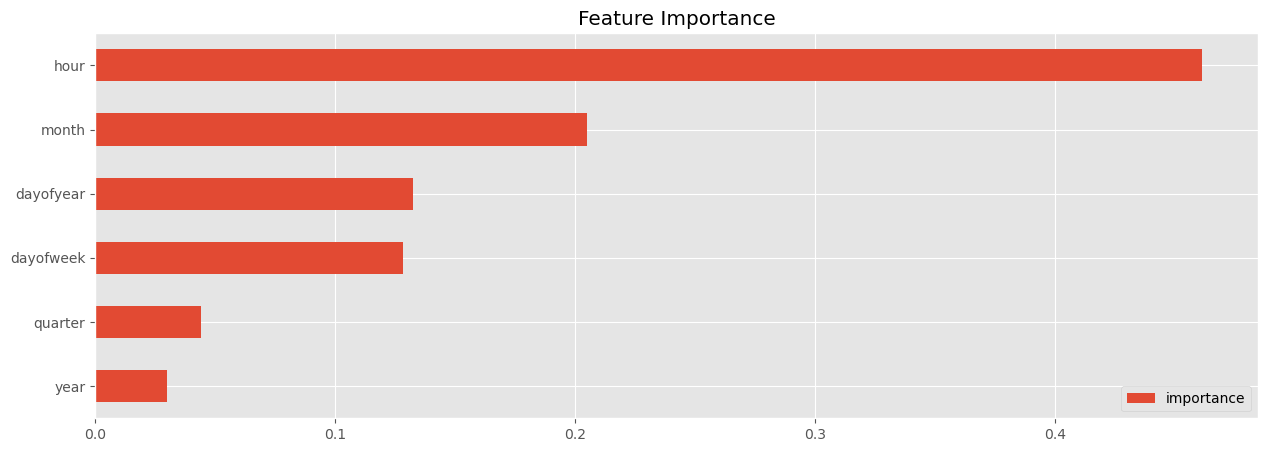

In [394]:
fi.plot(kind='barh', figsize=(15, 5), title='Feature Importance')
plt.show()

### Forecast on the Test set

In [395]:
test['prediction'] = reg.predict(X_test)

In [396]:
test.head()

,PJME,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,31733.287109
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,27754.167969
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,26861.980469
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26592.394531
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26592.394531


In [397]:
df_w_predictions = pjm3_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [398]:
create_features(df_w_predictions)

,PJME,prediction,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,,
2002-01-01 01:00:00,30393.0,NaN,1,1,1,1,2002,1
2002-01-01 02:00:00,29265.0,NaN,2,1,1,1,2002,1
2002-01-01 03:00:00,28357.0,NaN,3,1,1,1,2002,1
2002-01-01 04:00:00,27899.0,NaN,4,1,1,1,2002,1
2002-01-01 05:00:00,28057.0,NaN,5,1,1,1,2002,1
...,...,...,...,...,...,...,...,...
2018-08-02 20:00:00,44057.0,41472.394531,20,3,3,8,2018,214
2018-08-02 21:00:00,43256.0,40846.320312,21,3,3,8,2018,214
2018-08-02 22:00:00,41552.0,38270.093750,22,3,3,8,2018,214


Text(0.5, 1.0, 'Raw Data vs. Predictions')

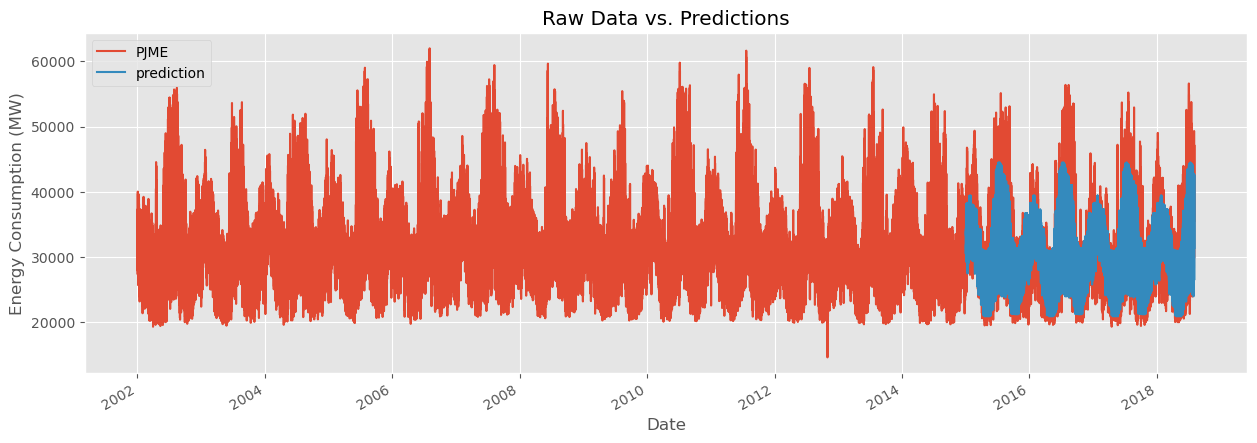

In [399]:
ax = df_w_predictions[['PJME', 'prediction']].plot(figsize=(15, 5), title='PJM East - Energy Use in MW')
ax.set_ylabel('Energy Consumption (MW)')
ax.set_xlabel('Date')
ax.set_title('Raw Data vs. Predictions')

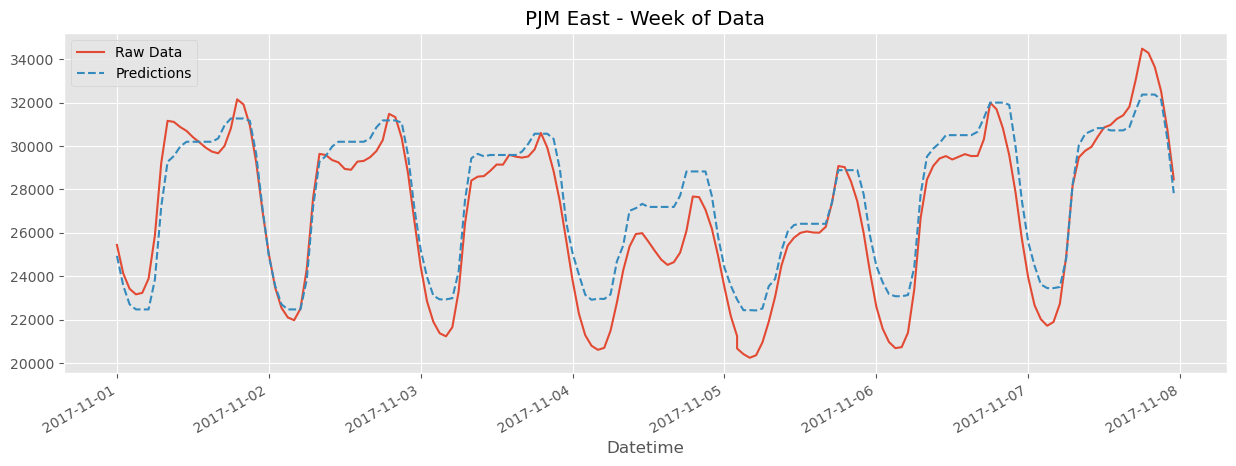

In [402]:
ax = df_w_predictions.loc[(df_w_predictions.index >= '2017-11-01') & (df_w_predictions.index < '2017-11-08')][['PJME', 'prediction']].\
    plot(figsize=(15, 5), title='PJM East - Week of Data', style=['-', '--'])
plt.legend(['Raw Data', 'Predictions'])
plt.show()

In [405]:
score = np.sqrt(mean_squared_error(test['PJME'], test['prediction']))
print(f'RMSE of test set: {round(score,4)}')

RMSE of test set: 3732.8471


### Calculate error
Look at the worst and best predicted days

In [407]:
test['error'] = np.abs(test['PJME'] - test['prediction'])

In [408]:
test['date'] = test.index.date

In [410]:
test.groupby('date')['error'].mean().sort_values(ascending=False).head(10)

date
2016-08-13    15061.483480
2016-08-14    14852.224609
2016-09-10    12478.755778
2016-09-09    11713.514648
2016-08-12    11243.524007
2018-01-06    11149.075439
2015-02-20    11086.833659
2018-01-07    10527.138753
2017-05-19    10351.015951
2015-02-16    10331.820150
Name: error, dtype: float64

In [411]:
test.groupby('date')['error'].mean().sort_values(ascending=True).head(10)

date
2016-05-01    348.449300
2018-05-17    392.697021
2016-09-27    409.223470
2015-12-19    445.596842
2015-09-22    467.810628
2016-04-04    470.950928
2015-09-25    481.584554
2016-12-08    494.750651
2016-05-06    502.420247
2016-10-08    506.144287
Name: error, dtype: float64

### Next steps
- more robust cross validation
- add more features